#**Indian Institute of Science Education and Research , Thiruvananthapuram**

#**Mathematical Foundations to Data Science (DSC 212)**

**Assignment Answers :**   

**Submitted by :- Anay Mishra, IMS24274, BS - MS 2024**

**Instructor : - Dr. Saptarshi Bej**

**[Click here for full assignment documentation (hosted at github)](https://github.com/astroanay/DSC-212-Assignment---Karate-Club-Analysis-by-Anay-Mishra-IMS24274.git)**

------------
-----------

/tmp/ipython-input-2755860725.py:101: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  nx.draw(G, pos, node_color=colors, cmap=plt.cm.get_cmap('tab10'),


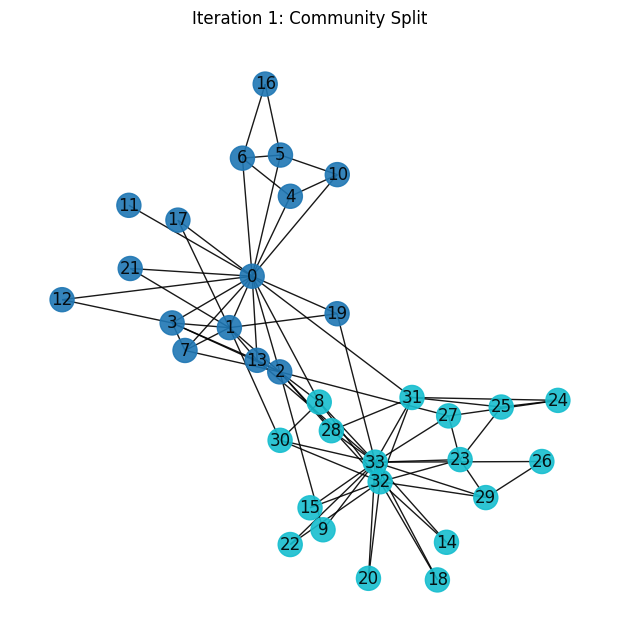

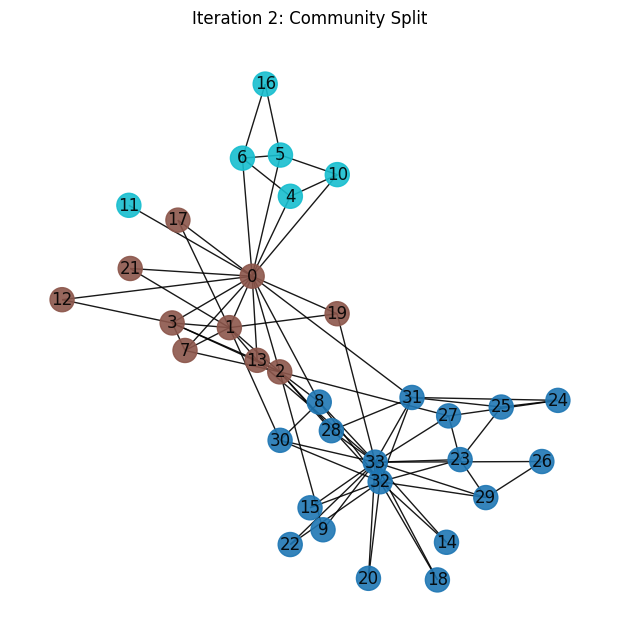

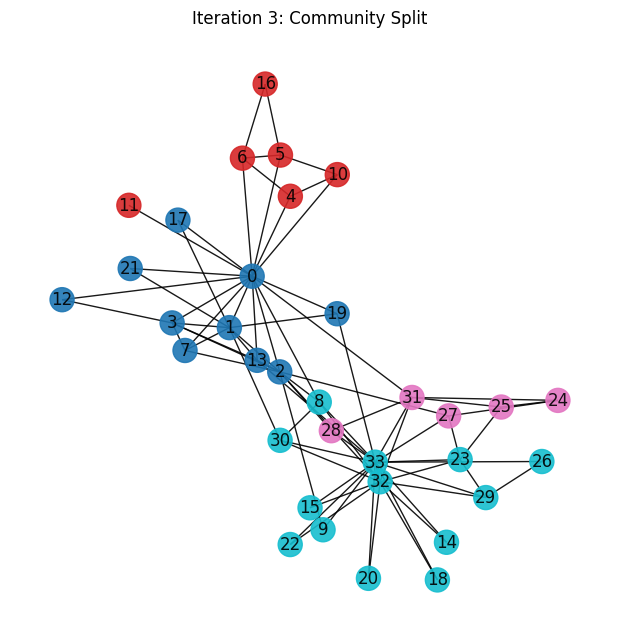

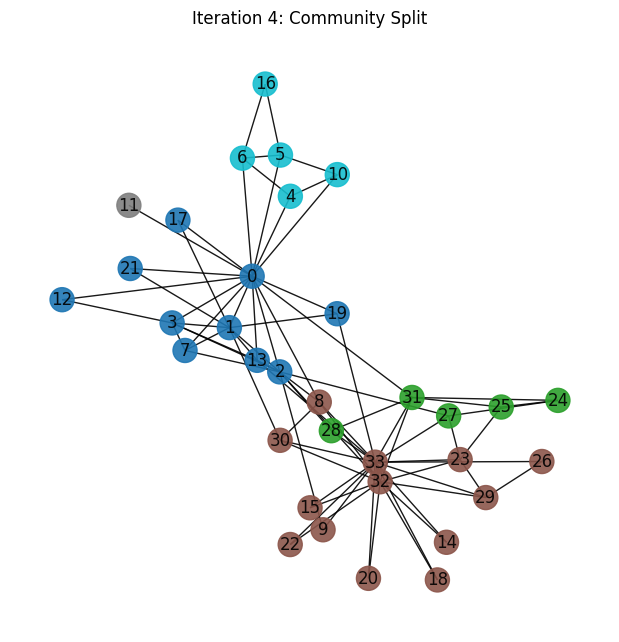

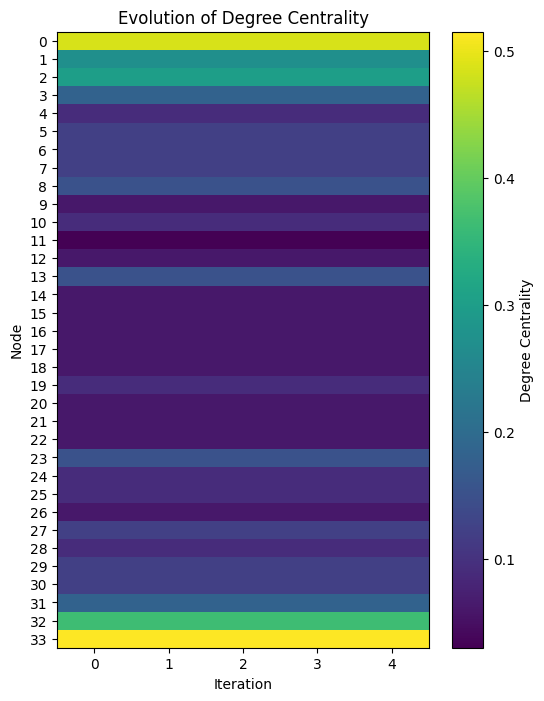

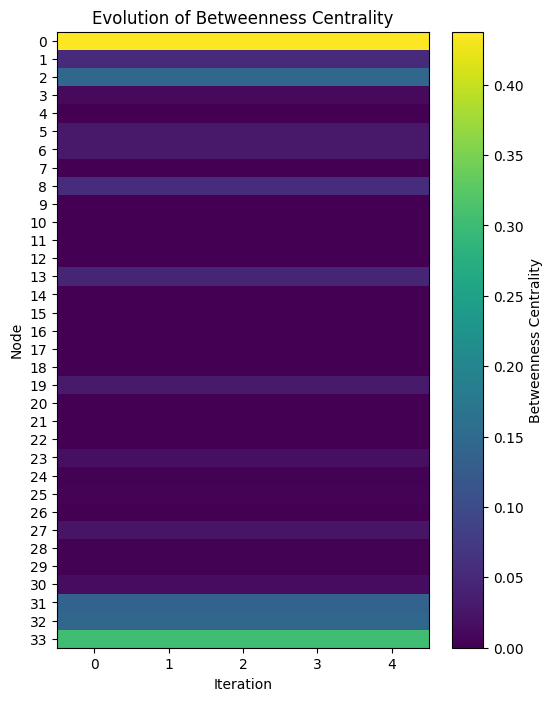

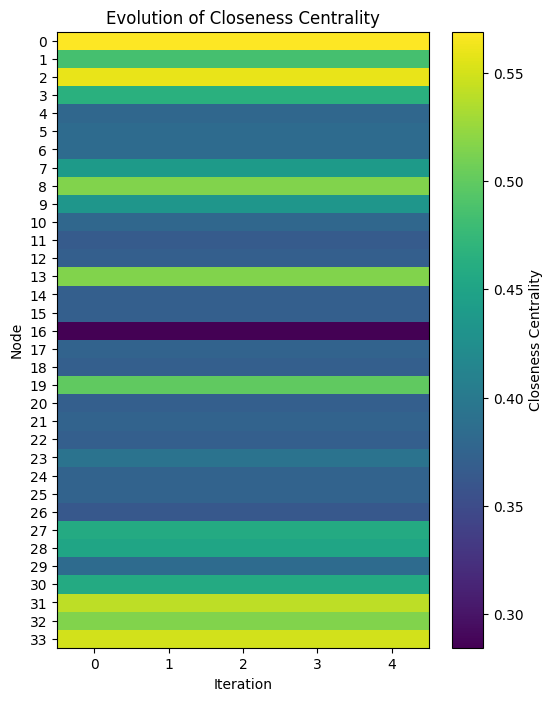

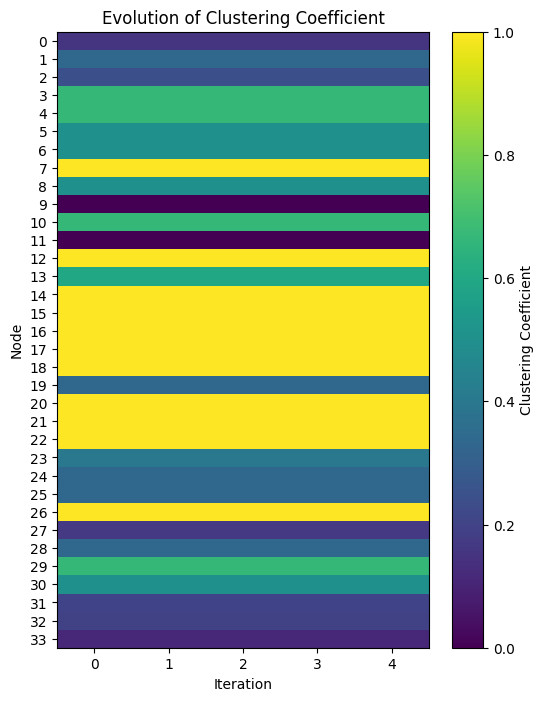

In [3]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# 1. Load Zachary's Karate Club graph from NetworkX
G = nx.karate_club_graph()

# Ensure graph is connected (it is for Karate Club) and get basic info
m = G.number_of_edges()               # total number of edges in the graph
deg = dict(G.degree())               # degree of each node in the original graph

# 2. Prepare for iterative partitioning
# Use a fixed layout so node positions stay the same across all plots
pos = nx.spring_layout(G, seed=42)

# Container for final communities (list of sets of nodes) and a queue for splitting
communities = [set(G.nodes())]       # start with all nodes as one community
queue = [set(G.nodes())]             # queue of communities to attempt to split

# 3. Prepare data structure to track centrality metrics over iterations
metrics_history = {node: {'degree': [], 'betweenness': [], 'closeness': [], 'clustering': []}
                   for node in G.nodes()}

# Function to compute the modularity matrix for a given community
def modularity_matrix(nodes_subset):
    """
    Compute the modularity matrix B for the subgraph induced by nodes_subset.
    B_ij = A_ij - (k_i * k_j) / (2m), where k are degrees in the original graph.
    """
    nodes_list = list(nodes_subset)
    size = len(nodes_list)
    B = np.zeros((size, size))
    for i, u in enumerate(nodes_list):
        for j, v in enumerate(nodes_list):
            if i == j:
                # Diagonal entry: no self-loop, so A_uu = 0
                B[i, i] = -deg[u] * deg[u] / (2 * m)
            else:
                # A_ij = 1 if edge exists, else 0
                A_uv = 1 if G.has_edge(u, v) else 0
                B[i, j] = A_uv - (deg[u] * deg[v]) / (2 * m)
    return B, nodes_list

# 4. Compute initial metrics (before any split, iteration 0)
initial_degree = nx.degree_centrality(G)
initial_betweenness = nx.betweenness_centrality(G)
initial_closeness = nx.closeness_centrality(G)
initial_clustering = nx.clustering(G)
for node in G.nodes():
    metrics_history[node]['degree'].append(initial_degree[node])
    metrics_history[node]['betweenness'].append(initial_betweenness[node])
    metrics_history[node]['closeness'].append(initial_closeness[node])
    metrics_history[node]['clustering'].append(initial_clustering[node])

iteration = 0  # count of splits performed

# 5. Recursive splitting loop
while queue:
    community = queue.pop(0)  # get the next community to test
    if len(community) <= 1:
        # Cannot split a community of size 0 or 1
        continue

    # Compute modularity matrix for this community
    B_sub, nodes_list = modularity_matrix(community)
    # Compute eigenvalues and eigenvectors (symmetric, so use eigh)
    eigenvals, eigenvecs = np.linalg.eigh(B_sub)
    # Largest eigenvalue is last one (eigh returns ascending order)
    leading_value = eigenvals[-1]
    leading_vec = eigenvecs[:, -1]

    # If the leading eigenvalue is positive, a split increases modularity
    if leading_value > 0:
        # Partition nodes by the sign of the leading eigenvector components
        group_pos = {nodes_list[i] for i, val in enumerate(leading_vec) if val > 0}
        group_neg = {nodes_list[i] for i, val in enumerate(leading_vec) if val <= 0}
        # Avoid empty splits
        if len(group_pos) == 0 or len(group_neg) == 0:
            continue

        # Replace the original community with the two new ones
        communities.remove(community)
        communities.append(group_pos)
        communities.append(group_neg)
        # Add new communities to queue for further splitting
        queue.append(group_pos)
        queue.append(group_neg)

        # Increment iteration count (a split has occurred)
        iteration += 1

        # 6. After the split, visualize the graph colored by community
        # Assign each community a unique color index
        node_color_map = {}
        for idx, comm in enumerate(communities):
            for node in comm:
                node_color_map[node] = idx
        # Create a list of colors for each node in sorted order of node labels
        colors = [node_color_map[node] for node in sorted(G.nodes())]
        plt.figure(figsize=(6,6))
        nx.draw(G, pos, node_color=colors, cmap=plt.cm.get_cmap('tab10'),
                with_labels=True, node_size=300, alpha=0.9)
        plt.title(f'Iteration {iteration}: Community Split')
        plt.show()

        # 7. Compute and store centrality metrics after this split
        deg_cent = nx.degree_centrality(G)
        bet_cent = nx.betweenness_centrality(G)
        clo_cent = nx.closeness_centrality(G)
        clu_cent = nx.clustering(G)
        for node in G.nodes():
            metrics_history[node]['degree'].append(deg_cent[node])
            metrics_history[node]['betweenness'].append(bet_cent[node])
            metrics_history[node]['closeness'].append(clo_cent[node])
            metrics_history[node]['clustering'].append(clu_cent[node])

# 8. Plot evolution of each metric across iterations
node_list = sorted(G.nodes())  # ensure consistent node order
num_iters = iteration + 1     # including initial metrics at iteration 0

# Prepare metric names and corresponding keys
metric_names = ['Degree Centrality', 'Betweenness Centrality',
                'Closeness Centrality', 'Clustering Coefficient']
metric_keys = ['degree', 'betweenness', 'closeness', 'clustering']

for name, key in zip(metric_names, metric_keys):
    # Build a matrix (nodes x iterations) of metric values
    data = np.array([metrics_history[node][key] for node in node_list])
    # Plot heatmap with nodes on y-axis and iterations on x-axis
    plt.figure(figsize=(6,8))
    plt.imshow(data, aspect='auto', cmap='viridis')
    plt.colorbar(label=name)
    plt.xticks(range(num_iters), range(num_iters))
    plt.yticks(range(len(node_list)), node_list)
    plt.xlabel('Iteration')
    plt.ylabel('Node')
    plt.title(f'Evolution of {name}')
    plt.show()

--------

### **Overview of the above code**

The code executes following steps:

1. Loads the Karate Club graph.
2. Uses spectral modularity bisection to repeatedly split the graph into communities.
3. After each split, computes centrality metrics:

   * Degree centrality
   * Betweenness centrality
   * Closeness centrality
   * Clustering coefficient
4. Tracks how each metric changes across iterations.
5. Visualizes:

   * Community structure after each split
   * Evolution of each centrality metric for every node.

---

### **Let's explain in a bit detail :**

#### 1. Loading the graph :
Loads a classic social network with 34 nodes (club members) and 78 edges (friendships).

#### 2. Initial setup

* m: total number of edges (used in modularity calculations).
* deg: stores degree of each node.


### Applying **Recursive Partitioning (Spectral Modularity) method**

#### 3. First phase

* All nodes start in one community.
* queue holds communities that still need to be checked for splitting.

#### 4. Modularity matrix

* Computes the **modularity matrix** B, where:

  * A_uv = 1 if edge exists between u and v, else 0.
  * The second term is the expected number of edges under a null model.
* Diagonal entries are - (deg[u]²) / 2m because A_uu = 0.

#### 5. **Spectral splitting**

* Uses the *leading eigenvector* of the modularity matrix.
* If the *leading eigenvalue > 0*, the community can be split.

#### 6. Partitioning nodes


* Splits nodes into two groups based on the sign of their entry in the leading eigenvector.

#### 7. Recursion

* Replaces the split community with its two children and enqueues them for further checking.



###  **Metric Computation and Tracking**

After each split, the code computes centralities for **all nodes** on the original graph:

* These are stored in metrics_history[node][metric] for every iteration.
( Although communities change, the **graph itself is static** — no edges are added/removed — so most centrality values remain stable, especially degree. )


### **Visualizing graphs**

#### 1. Community plots

* Each node is colored according to its community.
* Uses a fixed layout spring_layout for visual consistency across iterations.

#### 2. Metric evolution plots

* For each metric:

  * Builds a matrix: rows = nodes, columns = iterations.
  * Plots it as a heatmap.
  * Shows how each node’s centrality changes across iterations.



###  **Stopping Condition**

* Stops splitting when the leading eigenvalue is not positive — i.e., further partitioning would not improve modularity.

---

## Overall, following things can be achieved using this code :

* Automates community detection using a theoretically grounded method (spectral modularity).
* Visualizes how structure emerges, helping understand modularity and node roles.
* Quantifies node influence via centralities.
* Tracks persistence of centrality across community changes.

-------
-------